In [16]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import os
import sys
# Go up one folder from /notebooks to project root
sys.path.append(os.path.abspath(".."))
from data.model_utils import generate_all_signals, create_ml_features
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. 加载历史数据
df_data = pd.read_csv("../data/BTCUSDT_1min_2024-05-01_to_2025-05-01.csv", parse_dates=["timestamp"])
df_data.set_index("timestamp", inplace=True)

In [3]:
# Assign regime
def assign_regime(df):
    vol = df['close'].pct_change().rolling(30).std()
    ema_short = df['close'].ewm(span=12).mean()
    ema_long = df['close'].ewm(span=26).mean()
    trend = ema_short - ema_long

    regime = pd.Series(index=df.index, dtype=str)
    regime[(vol < vol.quantile(0.3)) & (trend > 0)] = 'bull_lowvol'
    regime[(vol > vol.quantile(0.7)) & (trend > 0)] = 'bull_highvol'
    regime[(trend < 0)] = 'bear'
    regime.fillna('neutral', inplace=True)

    return regime

df_data['regime'] = assign_regime(df_data)

In [4]:
def create_labels(close, horizon=5):
    return (close.shift(-horizon) > close).astype(int)

In [5]:
# Train one model per regime with thresholded 2-class labeling and confidence filtering
for regime_name in df_data['regime'].unique():
    print(f"\nTraining model for regime: {regime_name}")
    df_regime = df_data[df_data['regime'] == regime_name].copy()

    signals = generate_all_signals(df_regime)
    features = create_ml_features(signals, df_regime['close'])

    def create_labels(close, horizon=5, threshold=0.0005):
        ret = close.shift(-horizon) / close - 1
        return np.where(ret > threshold, 1, np.where(ret < -threshold, 0, np.nan))

    raw_labels = create_labels(df_regime['close'])
    raw_labels = pd.Series(raw_labels, index=df_regime.index)
    raw_labels = raw_labels.loc[features.index].dropna()
    features = features.loc[raw_labels.index]

    labels = raw_labels.astype(int)

    # Filter out if too small
    if len(features) < 100:
        print(f"[Skipped] Not enough data for regime: {regime_name}")
        continue

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(n_estimators=100, max_depth=3))
    ])

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    model.fit(X_train, y_train)

    print(classification_report(y_test, model.predict(X_test)))

    joblib.dump(model, f"../notebooks/xgb_model_{regime_name}.pkl")
    print(f"Saved: xgb_model_{regime_name}.pkl")



Training model for regime: neutral
              precision    recall  f1-score   support

           0       0.55      0.44      0.49      1803
           1       0.60      0.70      0.64      2128

    accuracy                           0.58      3931
   macro avg       0.58      0.57      0.57      3931
weighted avg       0.58      0.58      0.57      3931

Saved: xgb_model_neutral.pkl

Training model for regime: bear
              precision    recall  f1-score   support

           0       0.60      0.69      0.64      2671
           1       0.57      0.47      0.52      2331

    accuracy                           0.59      5002
   macro avg       0.58      0.58      0.58      5002
weighted avg       0.58      0.59      0.58      5002

Saved: xgb_model_bear.pkl

Training model for regime: bull_highvol
              precision    recall  f1-score   support

           0       0.55      0.43      0.48      1544
           1       0.59      0.70      0.64      1817

    accuracy     

In [11]:
def hit_rate_only(preds, true_labels):
    aligned = pd.Series(preds, index=true_labels.index)
    return (aligned == true_labels).mean()

# 模型预测
preds = model.predict(X_test)
y_test = y_test.loc[X_test.index]  # align index
hit_model = hit_rate_only(preds, y_test)

# BuyHold（全预测为上涨）
hit_buyhold = hit_rate_only(np.ones_like(y_test), y_test)

# Random
np.random.seed(42)
hit_random = hit_rate_only(np.random.choice([0, 1], len(y_test)), y_test)

# 输出
print("\n Prediction Hit Rate Comparison:")
print(pd.DataFrame({
    "Model": [hit_model],
    "BuyHold": [hit_buyhold],
    "Random": [hit_random]
}).T.rename(columns={0: "Hit Rate"}))



 Prediction Hit Rate Comparison:
         Hit Rate
Model    0.624016
BuyHold  0.563484
Random   0.514272


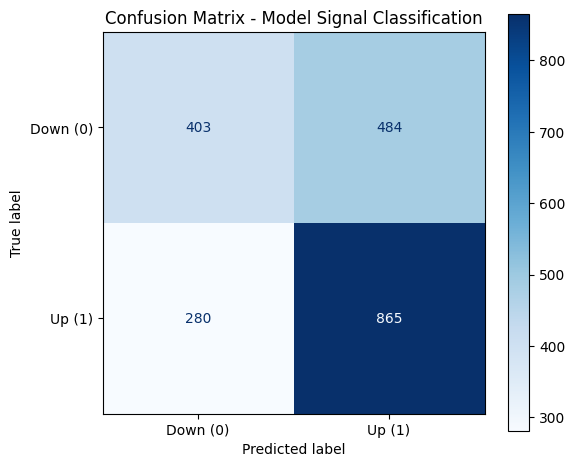

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: 获取真实标签和预测标签
true_labels = y_test
predicted_labels = model.predict(X_test)

# Step 2: 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])

# Step 3: 可视化
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Model Signal Classification")
plt.tight_layout()
plt.show()


In [ ]:
def plot_feature_importance(model_pipeline, feature_names, top_n=15):
    """提取并可视化 XGBoost 模型中的特征重要性"""
    booster = model_pipeline.named_steps['xgb']  # 获取管道中的 XGBoost 模型
    importances = booster.feature_importances_
    
    # 排序并转换为 DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    # 可视化
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Top Feature Importances (XGBoost)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


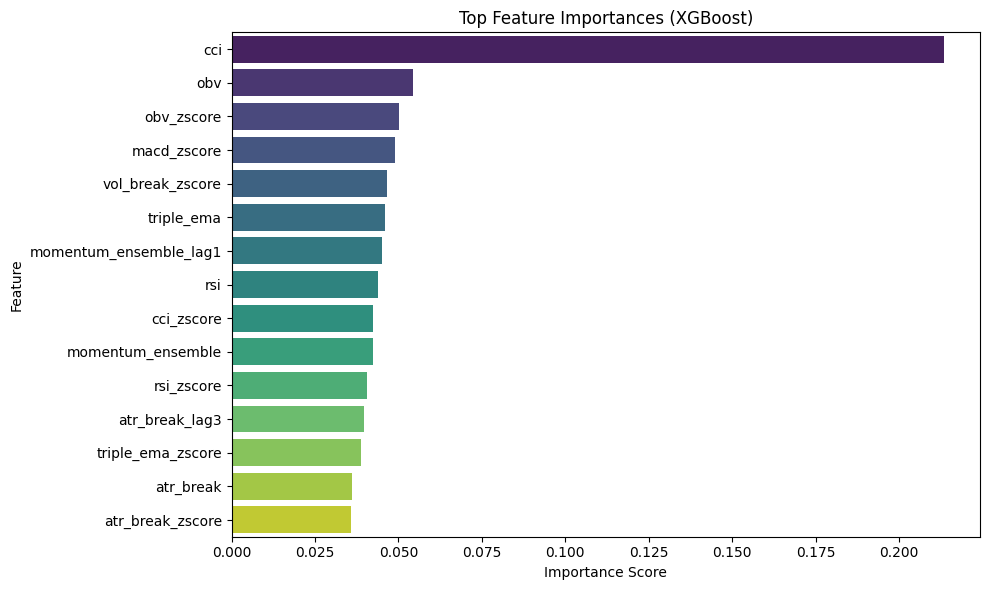

In [14]:
# 假设你刚训练完模型，features 是训练用的特征 DataFrame
plot_feature_importance(model, features.columns)
